In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report
from sklearn.inspection import PartialDependenceDisplay


In [3]:
# read crux data
crux_r1_l1 = pd.read_csv("./cruxeval/tree_stats/r1_level1_output.csv")
crux_r1_l2 = pd.read_csv("./cruxeval/tree_stats/r1_level2_output.csv")
crux_r1_l3 = pd.read_csv("./cruxeval/tree_stats/r1_level3_output.csv")

crux_qwq_l1 = pd.read_csv("./cruxeval/tree_stats/qwq_level1_output.csv")
crux_qwq_l2 = pd.read_csv("./cruxeval/tree_stats/qwq_level2_output.csv")
crux_qwq_l3 = pd.read_csv("./cruxeval/tree_stats/qwq_level3_output.csv")

# read safim data
safim_block_r1_l1 = pd.read_csv("./safim/tree_stats/r1_level1_block.csv")
safim_block_r1_l2 = pd.read_csv("./safim/tree_stats/r1_level2_block.csv")
safim_block_r1_l3 = pd.read_csv("./safim/tree_stats/r1_level3_block.csv")

safim_block_qwq_l1 = pd.read_csv("./safim/tree_stats/qwq_level1_block.csv")
safim_block_qwq_l2 = pd.read_csv("./safim/tree_stats/qwq_level2_block.csv")
safim_block_qwq_l3 = pd.read_csv("./safim/tree_stats/qwq_level3_block.csv")

codelingua_r1_l1 = pd.read_csv("./codelingua/tree_stats_combined/r1_level1.csv")
codelingua_r1_l2 = pd.read_csv("./codelingua/tree_stats_combined/r1_level2.csv")
codelingua_r1_l3 = pd.read_csv("./codelingua/tree_stats_combined/r1_level3.csv")

codelingua_qwq_l1 = pd.read_csv("./codelingua/tree_stats_combined/qwq_level1.csv")
codelingua_qwq_l2 = pd.read_csv("./codelingua/tree_stats_combined/qwq_level2.csv")
codelingua_qwq_l3 = pd.read_csv("./codelingua/tree_stats_combined/qwq_level3.csv")

In [4]:
def train(data, model_name, random_state=42, n_estimators=50, max_depth=5, top_n=6):
    if "score" in data.columns:
        data = data.drop(["score"], axis=1)
    # if "total_segments" in data.columns:
    #     data = data.drop(["total_segments"], axis=1)
    X = data.drop(["file", "state"], axis = 1)
    Y = data["state"]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state, stratify=Y)
    if model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion="entropy", class_weight="balanced", random_state=random_state)
    elif model_name == "AdaBoost":
        model = AdaBoostClassifier(n_estimators=100, random_state=random_state)
    else:
        raise ValueError(f"Unsupported model name: {model_name}")
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    f1 = f1_score(Y_test, Y_pred, average='weighted')
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='weighted', zero_division=0)
    recall = recall_score(Y_test, Y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    importances = model.feature_importances_
    feature_names = X.columns
    feat_importances = pd.Series(importances, index=feature_names)
    top_features = feat_importances.nlargest(top_n).index.tolist()
    fig, ax = plt.subplots(figsize=(12, 8))
    display = PartialDependenceDisplay.from_estimator(
        model, 
        X_train, 
        features=top_features,  # Only the most important ones
        ax=ax,
        grid_resolution=50,
    )

    plt.tight_layout()
    display.figure_.savefig(
        "partial_dependence.png",
        bbox_inches="tight",
        dpi=300,
    )  
    plt.show()
        
    report = classification_report(Y_test, Y_pred, zero_division=0)
    print("Classification Report per Class:")
    print(report)

    # report = classification_report(model.predict(X_train), Y_train, zero_division=0)
    # print("Training Classification Report per Class:")
    # print(report)

    return model

def eval(model, data):
    # if "total_segments" in data.columns:
    #     data = data.drop(["total_segments"], axis=1)
    X = data.drop(["file", "state"], axis = 1)
    Y = data["state"]
    Y_pred = model.predict(X)
    f1 = f1_score(Y, Y_pred, average='weighted')
    accuracy = accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred, average='weighted', zero_division=0)
    recall = recall_score(Y, Y_pred, average='weighted')
    print(f"Eval F1 Score: {f1:.4f}")
    print(f"Eval Accuracy: {accuracy:.4f}")
    print(f"Eval Precision: {precision:.4f}")
    print(f"Eval Recall: {recall:.4f}")

    report = classification_report(Y, Y_pred, zero_division=0)
    print("Classification Report per Class:")
    print(report)

    return Y_pred

Codelingua L1 training results: 
F1 Score: 0.7449
Accuracy: 0.7333
Precision: 0.7627
Recall: 0.7333


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 48 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.war

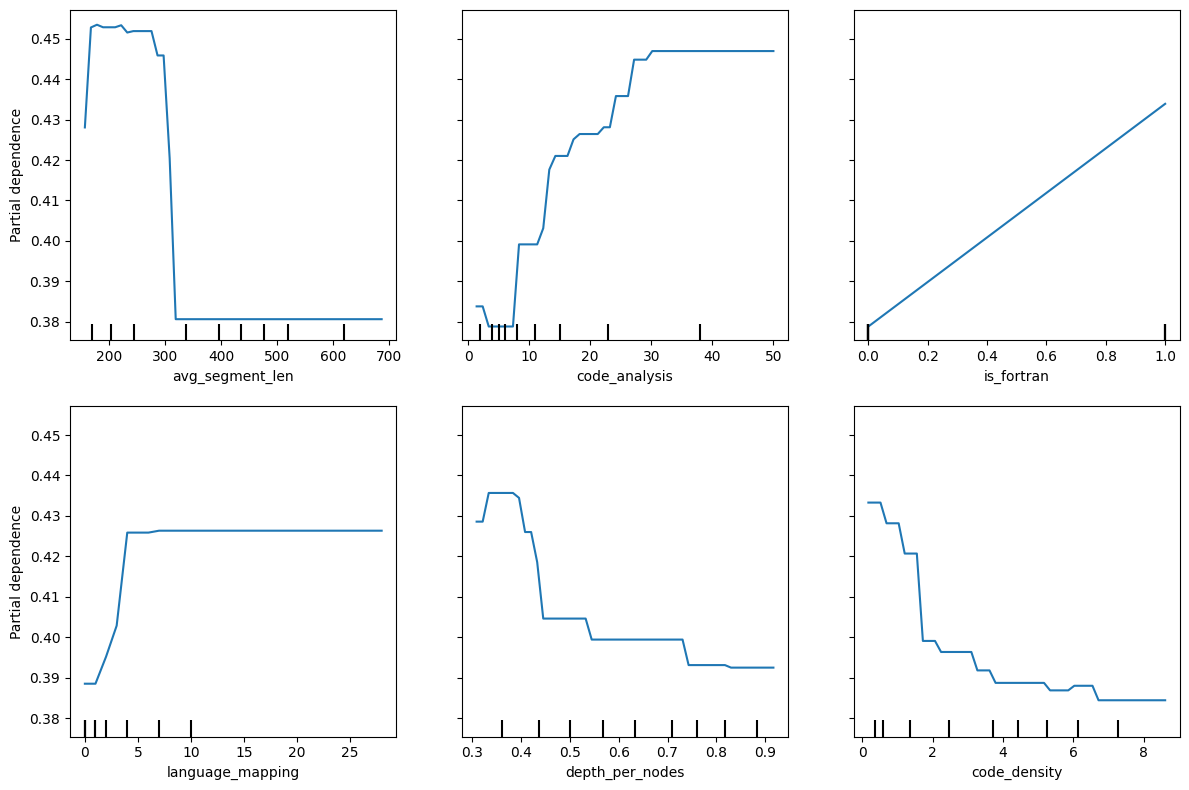

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.86      0.79      0.82       117
   incorrect       0.42      0.55      0.47        33

    accuracy                           0.73       150
   macro avg       0.64      0.67      0.65       150
weighted avg       0.76      0.73      0.74       150

Codelingua L1 predict on L2: 
Eval F1 Score: 0.7638
Eval Accuracy: 0.7507
Eval Precision: 0.7909
Eval Recall: 0.7507
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.89      0.77      0.83       576
   incorrect       0.47      0.67      0.56       174

    accuracy                           0.75       750
   macro avg       0.68      0.72      0.69       750
weighted avg       0.79      0.75      0.76       750

Codelingua L1 predict on L3: 
Eval F1 Score: 0.7678
Eval Accuracy: 0.7587
Eval Precision: 0.7856
Eval Recall: 0.7587
Classification Report per Class:
             

In [ ]:
# codelingua r1
print("Codelingua L1 training results: ")
model = train(codelingua_r1_l1, "RandomForest", n_estimators=50, max_depth=3)
print("Codelingua L1 predict on L2: ")
RESULTS = eval(model, codelingua_r1_l2)
print("Codelingua L1 predict on L3: ")
RESULTS = eval(model, codelingua_r1_l3)

Codelingua L1 training results: 
F1 Score: 0.6771
Accuracy: 0.6800
Precision: 0.6752
Recall: 0.6800


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


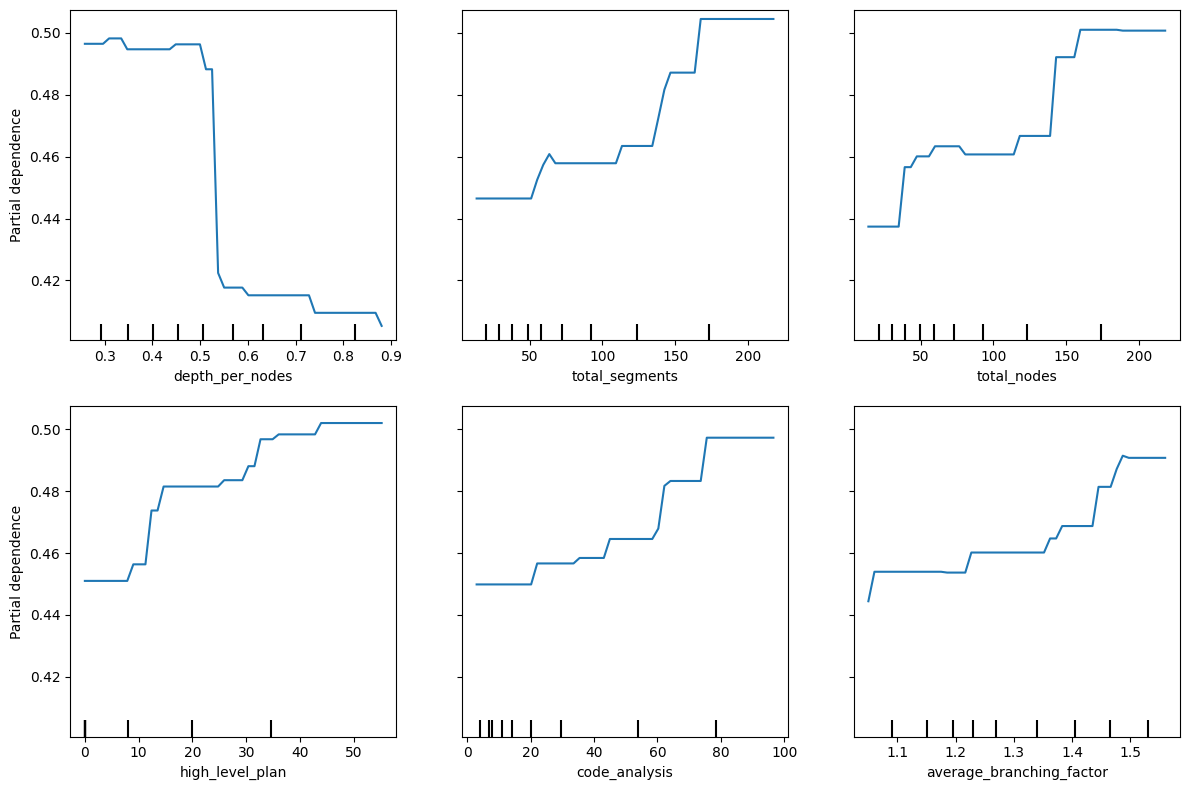

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.74      0.77      0.76        96
   incorrect       0.56      0.52      0.54        54

    accuracy                           0.68       150
   macro avg       0.65      0.64      0.65       150
weighted avg       0.68      0.68      0.68       150

Codelingua L1 predict on L2: 
Eval F1 Score: 0.6727
Eval Accuracy: 0.6756
Eval Precision: 0.6758
Eval Recall: 0.6756
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.67      0.76      0.71       399
   incorrect       0.68      0.58      0.63       350

    accuracy                           0.68       749
   macro avg       0.68      0.67      0.67       749
weighted avg       0.68      0.68      0.67       749

Codelingua L1 predict on L3: 
Eval F1 Score: 0.6432
Eval Accuracy: 0.6519
Eval Precision: 0.6794
Eval Recall: 0.6519
Classification Report per Class:
             

In [6]:
# codelingua qwq
print("Codelingua L1 training results: ")
model = train(codelingua_qwq_l1, "RandomForest", n_estimators=50, max_depth=3)
print("Codelingua L1 predict on L2: ")
RESULTS = eval(model, codelingua_qwq_l2)
print("Codelingua L1 predict on L3: ")
RESULTS = eval(model, codelingua_qwq_l3)

Safim L1 training results: 
F1 Score: 0.7856
Accuracy: 0.7900
Precision: 0.7840
Recall: 0.7900


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 42 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.war

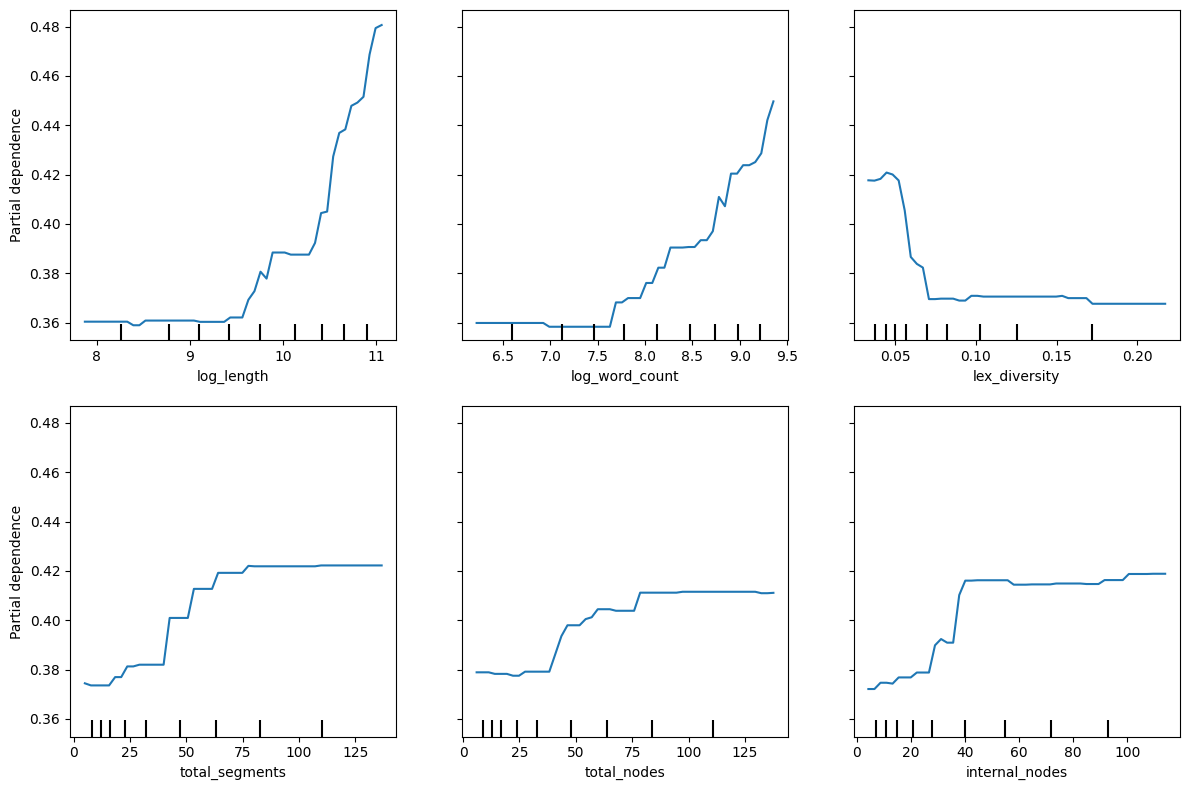

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.83      0.88      0.85       139
   incorrect       0.68      0.59      0.63        61

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.78      0.79      0.79       200

Safim L1 predict on L2: 
Eval F1 Score: 0.7941
Eval Accuracy: 0.8275
Eval Precision: 0.7909
Eval Recall: 0.8275
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.51      0.19      0.28       139
   incorrect       0.85      0.96      0.90       661

    accuracy                           0.83       800
   macro avg       0.68      0.58      0.59       800
weighted avg       0.79      0.83      0.79       800

Safim L1 predict on L3: 
Eval F1 Score: 0.7883
Eval Accuracy: 0.8119
Eval Precision: 0.7750
Eval Recall: 0.8119
Classification Report per Class:
              precision

In [7]:
# safim r1
print("Safim L1 training results: ")
model = train(safim_block_r1_l1, "RandomForest", n_estimators=50, max_depth=5, top_n=6)
print("Safim L1 predict on L2: ")
RESULTS = eval(model, safim_block_r1_l2)
print("Safim L1 predict on L3: ")
RESULTS = eval(model, safim_block_r1_l3)

Safim L1 training results: 
F1 Score: 0.7896
Accuracy: 0.7908
Precision: 0.8005
Recall: 0.7908


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn

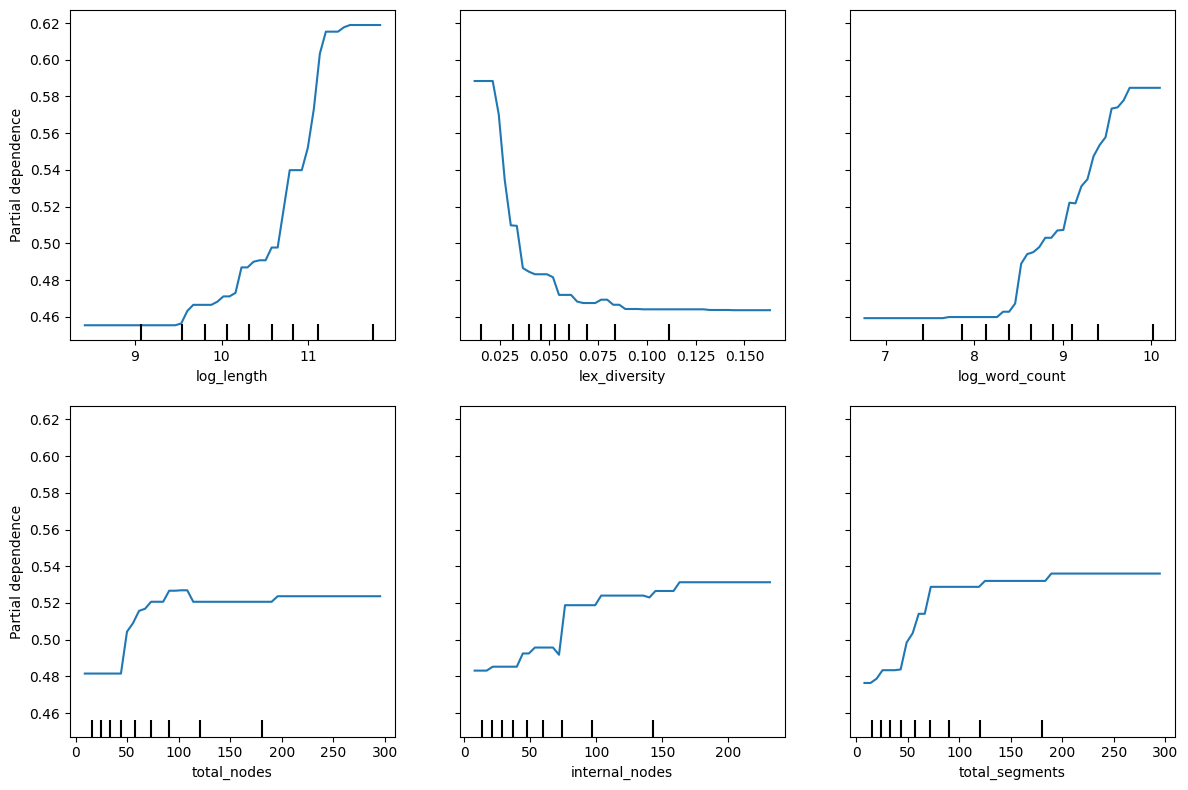

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.74      0.88      0.80        96
   incorrect       0.86      0.71      0.78       100

    accuracy                           0.79       196
   macro avg       0.80      0.79      0.79       196
weighted avg       0.80      0.79      0.79       196

Safim L1 predict on L2: 
Eval F1 Score: 0.7746
Eval Accuracy: 0.7354
Eval Precision: 0.8546
Eval Recall: 0.7354
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.28      0.68      0.40       124
   incorrect       0.94      0.74      0.83       836

    accuracy                           0.74       960
   macro avg       0.61      0.71      0.61       960
weighted avg       0.85      0.74      0.77       960

Safim L1 predict on L3: 
Eval F1 Score: 0.7710
Eval Accuracy: 0.7114
Eval Precision: 0.9010
Eval Recall: 0.7114
Classification Report per Class:
              precision

In [8]:
# safim qwq
print("Safim L1 training results: ")
model = train(safim_block_qwq_l1, "RandomForest", n_estimators=50, max_depth=5)
print("Safim L1 predict on L2: ")
RESULTS = eval(model, safim_block_qwq_l2)
print("Safim L1 predict on L3: ")
RESULTS = eval(model, safim_block_qwq_l3)

Crux R1 L1 training results: 
F1 Score: 0.8992
Accuracy: 0.8812
Precision: 0.9230
Recall: 0.8812


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 42 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 48 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.wa

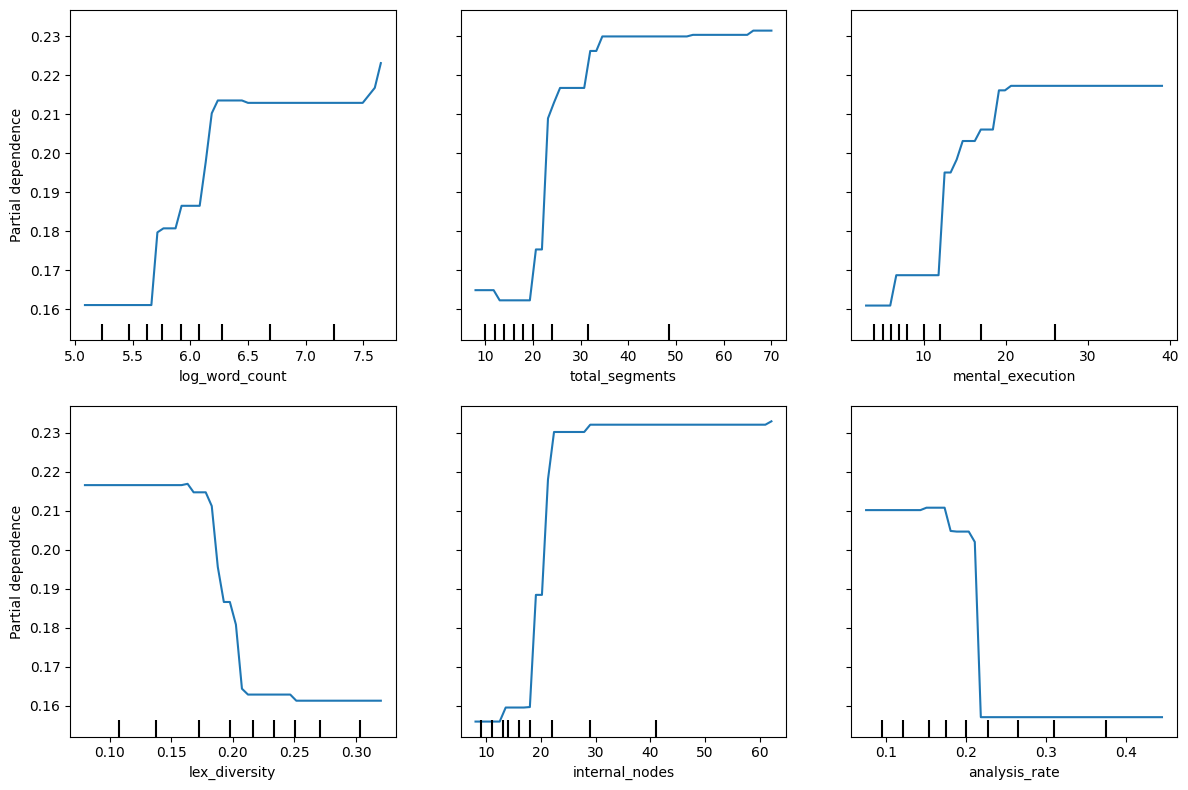

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.96      0.91      0.94       151
   incorrect       0.22      0.44      0.30         9

    accuracy                           0.88       160
   macro avg       0.59      0.68      0.62       160
weighted avg       0.92      0.88      0.90       160

Crux R1 L1 predict on L2: 
Eval F1 Score: 0.7456
Eval Accuracy: 0.7512
Eval Precision: 0.7408
Eval Recall: 0.7512
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.83      0.86      0.85       633
   incorrect       0.39      0.35      0.37       167

    accuracy                           0.75       800
   macro avg       0.61      0.60      0.61       800
weighted avg       0.74      0.75      0.75       800

Crux R1 L1 predict on L3: 
Eval F1 Score: 0.7368
Eval Accuracy: 0.7275
Eval Precision: 0.7489
Eval Recall: 0.7275
Classification Report per Class:
              preci

In [9]:
# crux r1
print("Crux R1 L1 training results: ")
model = train(crux_r1_l1, "RandomForest", n_estimators=50, max_depth=4)
print("Crux R1 L1 predict on L2: ")
RESULTS = eval(model, crux_r1_l2)
print("Crux R1 L1 predict on L3: ")
RESULTS = eval(model, crux_r1_l3)

Crux QwQ L1 training results: 
F1 Score: 0.8820
Accuracy: 0.8875
Precision: 0.8805
Recall: 0.8875


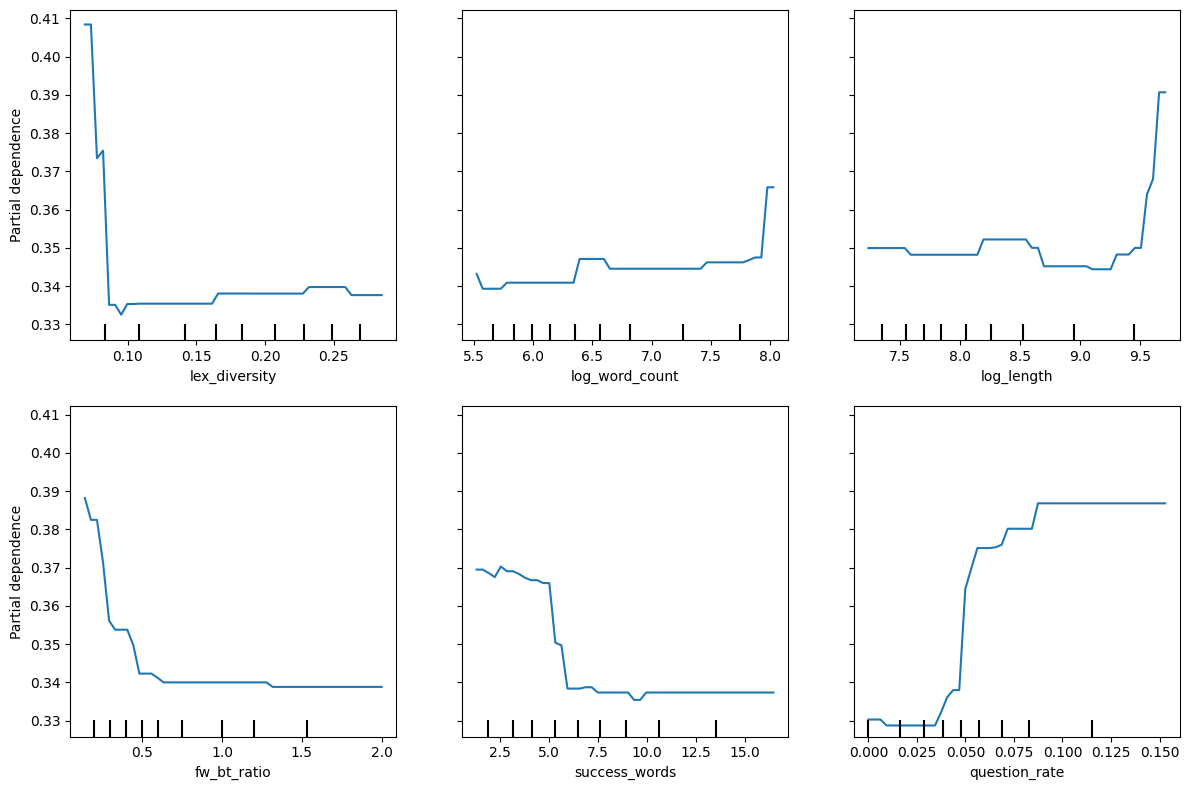

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.91      0.95      0.93       132
   incorrect       0.73      0.57      0.64        28

    accuracy                           0.89       160
   macro avg       0.82      0.76      0.79       160
weighted avg       0.88      0.89      0.88       160

Crux QwQ L1 predict on L2: 
Eval F1 Score: 0.7700
Eval Accuracy: 0.7673
Eval Precision: 0.7734
Eval Recall: 0.7673
Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.85      0.83      0.84       596
   incorrect       0.53      0.57      0.55       199

    accuracy                           0.77       795
   macro avg       0.69      0.70      0.70       795
weighted avg       0.77      0.77      0.77       795

Crux QwQ L1 predict on L3: 
Eval F1 Score: 0.7437
Eval Accuracy: 0.7357
Eval Precision: 0.7570
Eval Recall: 0.7357
Classification Report per Class:
              pre

In [10]:
# crux qwq
print("Crux QwQ L1 training results: ")
model = train(crux_qwq_l1, "RandomForest", n_estimators=50, max_depth=4)
print("Crux QwQ L1 predict on L2: ")
RESULTS = eval(model, crux_qwq_l2)
print("Crux QwQ L1 predict on L3: ")
RESULTS = eval(model, crux_qwq_l3)

Classification Report per Class:
              precision    recall  f1-score   support

     correct       0.82      0.84      0.83      1274
   incorrect       0.77      0.75      0.76       942

    accuracy                           0.80      2216
   macro avg       0.80      0.79      0.79      2216
weighted avg       0.80      0.80      0.80      2216

Top 10: ['log_word_count' 'lex_diversity' 'log_length' 'total_segments'
 'leaf_nodes' 'internal_nodes' 'code_density' 'high_level_plan'
 'code_analysis' 'max_segment_len']


/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/Users/fangjiaxin/Desktop/lmcode/thought-tree-analysis/.venv/lib/python3.10/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 2 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn

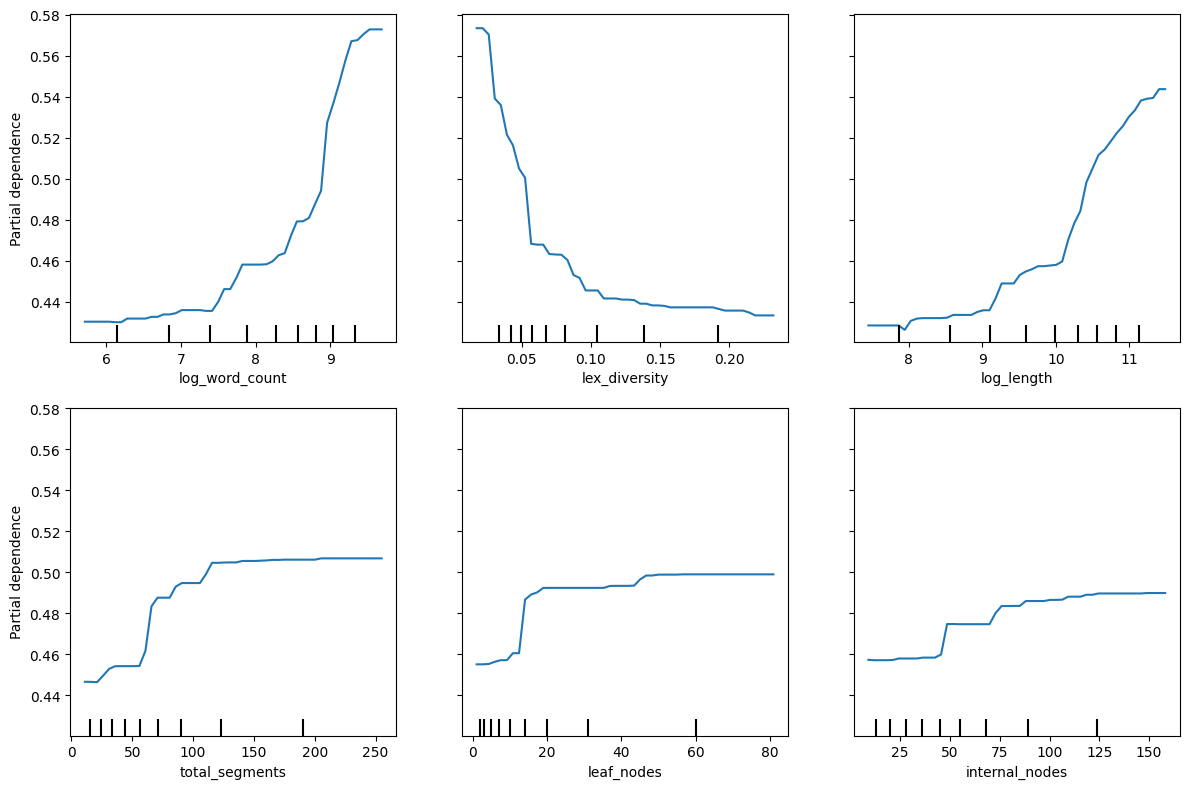

In [11]:
# combine safim + crux + codelingua

# combine r1 safim
X = safim_block_r1_l1.drop(["file", "state"], axis = 1)
Y = safim_block_r1_l1["state"]
x_l1_safim_r1_train, x_l1_safim_r1_test, y_l1_safim_r1_train, y_l1_safim_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = safim_block_r1_l2.drop(["file", "state"], axis = 1)
Y = safim_block_r1_l2["state"]
x_l2_safim_r1_train, x_l2_safim_r1_test, y_l2_safim_r1_train, y_l2_safim_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = safim_block_r1_l3.drop(["file", "state"], axis = 1)
Y = safim_block_r1_l3["state"]
x_l3_safim_r1_train, x_l3_safim_r1_test, y_l3_safim_r1_train, y_l3_safim_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_safim_r1_train = pd.concat([x_l1_safim_r1_train, x_l2_safim_r1_train, x_l3_safim_r1_train], axis=0)
combined_y_safim_r1_train = pd.concat([y_l1_safim_r1_train, y_l2_safim_r1_train, y_l3_safim_r1_train], axis=0)
combined_x_safim_r1_test = pd.concat([x_l1_safim_r1_test, x_l2_safim_r1_test, x_l3_safim_r1_test], axis=0)
combined_y_safim_r1_test = pd.concat([y_l1_safim_r1_test, y_l2_safim_r1_test, y_l3_safim_r1_test], axis=0)

# combine qwq safim
X = safim_block_qwq_l1.drop(["file", "state"], axis = 1)
Y = safim_block_qwq_l1["state"]
x_l1_safim_qwq_train, x_l1_safim_qwq_test, y_l1_safim_qwq_train, y_l1_safim_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = safim_block_qwq_l2.drop(["file", "state"], axis = 1)
Y = safim_block_qwq_l2["state"]
x_l2_safim_qwq_train, x_l2_safim_qwq_test, y_l2_safim_qwq_train, y_l2_safim_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = safim_block_qwq_l3.drop(["file", "state"], axis = 1)
Y = safim_block_qwq_l3["state"]
x_l3_safim_qwq_train, x_l3_safim_qwq_test, y_l3_safim_qwq_train, y_l3_safim_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_safim_qwq_train = pd.concat([x_l1_safim_qwq_train, x_l2_safim_qwq_train, x_l3_safim_qwq_train], axis=0)
combined_y_safim_qwq_train = pd.concat([y_l1_safim_qwq_train, y_l2_safim_qwq_train, y_l3_safim_qwq_train], axis=0)
combined_x_safim_qwq_test = pd.concat([x_l1_safim_qwq_test, x_l2_safim_qwq_test, x_l3_safim_qwq_test], axis=0)
combined_y_safim_qwq_test = pd.concat([y_l1_safim_qwq_test, y_l2_safim_qwq_test, y_l3_safim_qwq_test], axis=0)

# combine r1 crux
X = crux_r1_l1.drop(["file", "state"], axis = 1)
Y = crux_r1_l1["state"]
x_l1_crux_r1_train, x_l1_crux_r1_test, y_l1_crux_r1_train, y_l1_crux_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = crux_r1_l2.drop(["file", "state"], axis = 1)
Y = crux_r1_l2["state"]
x_l2_crux_r1_train, x_l2_crux_r1_test, y_l2_crux_r1_train, y_l2_crux_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = crux_r1_l3.drop(["file", "state"], axis = 1)
Y = crux_r1_l3["state"]
x_l3_crux_r1_train, x_l3_crux_r1_test, y_l3_crux_r1_train, y_l3_crux_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_crux_r1_train = pd.concat([x_l1_crux_r1_train, x_l2_crux_r1_train, x_l3_crux_r1_train], axis=0)
combined_y_crux_r1_train = pd.concat([y_l1_crux_r1_train, y_l2_crux_r1_train, y_l3_crux_r1_train], axis=0)
combined_x_crux_r1_test = pd.concat([x_l1_crux_r1_test, x_l2_crux_r1_test, x_l3_crux_r1_test], axis=0)
combined_y_crux_r1_test = pd.concat([y_l1_crux_r1_test, y_l2_crux_r1_test, y_l3_crux_r1_test], axis=0)

# combine qwq crux
X = crux_qwq_l1.drop(["file", "state"], axis = 1)
Y = crux_qwq_l1["state"]
x_l1_crux_qwq_train, x_l1_crux_qwq_test, y_l1_crux_qwq_train, y_l1_crux_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = crux_qwq_l2.drop(["file", "state"], axis = 1)
Y = crux_qwq_l2["state"]
x_l2_crux_qwq_train, x_l2_crux_qwq_test, y_l2_crux_qwq_train, y_l2_crux_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = crux_qwq_l3.drop(["file", "state"], axis = 1)
Y = crux_qwq_l3["state"]
x_l3_crux_qwq_train, x_l3_crux_qwq_test, y_l3_crux_qwq_train, y_l3_crux_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_crux_qwq_train = pd.concat([x_l1_crux_qwq_train, x_l2_crux_qwq_train, x_l3_crux_qwq_train], axis=0)
combined_y_crux_qwq_train = pd.concat([y_l1_crux_qwq_train, y_l2_crux_qwq_train, y_l3_crux_qwq_train], axis=0)
combined_x_crux_qwq_test = pd.concat([x_l1_crux_qwq_test, x_l2_crux_qwq_test, x_l3_crux_qwq_test], axis=0)
combined_y_crux_qwq_test = pd.concat([y_l1_crux_qwq_test, y_l2_crux_qwq_test, y_l3_crux_qwq_test], axis=0)

# combine r1 codelingua
X = codelingua_r1_l1.drop(["file", "state"], axis = 1)
Y = codelingua_r1_l1["state"]
x_l1_clg_r1_train, x_l1_clg_r1_test, y_l1_clg_r1_train, y_l1_clg_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = codelingua_r1_l2.drop(["file", "state"], axis = 1)
Y = codelingua_r1_l2["state"]
x_l2_clg_r1_train, x_l2_clg_r1_test, y_l2_clg_r1_train, y_l2_clg_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = codelingua_r1_l3.drop(["file", "state"], axis = 1)
Y = codelingua_r1_l3["state"]
x_l3_clg_r1_train, x_l3_clg_r1_test, y_l3_clg_r1_train, y_l3_clg_r1_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_codelingua_r1_train = pd.concat([x_l1_clg_r1_train, x_l2_clg_r1_train, x_l3_clg_r1_train], axis=0)
combined_y_codelingua_r1_train = pd.concat([y_l1_clg_r1_train, y_l2_clg_r1_train, y_l3_clg_r1_train], axis=0)
combined_x_codelingua_r1_test = pd.concat([x_l1_clg_r1_test, x_l2_clg_r1_test, x_l3_clg_r1_test], axis=0)
combined_y_codelingua_r1_test = pd.concat([y_l1_clg_r1_test, y_l2_clg_r1_test, y_l3_clg_r1_test], axis=0)

# combine qwq codelingua
X = codelingua_qwq_l1.drop(["file", "state"], axis = 1)
Y = codelingua_qwq_l1["state"]
x_l1_clg_qwq_train, x_l1_clg_qwq_test, y_l1_clg_qwq_train, y_l1_clg_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = codelingua_qwq_l2.drop(["file", "state"], axis = 1)
Y = codelingua_qwq_l2["state"]
x_l2_clg_qwq_train, x_l2_clg_qwq_test, y_l2_clg_qwq_train, y_l2_clg_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

X = codelingua_qwq_l3.drop(["file", "state"], axis = 1)
Y = codelingua_qwq_l3["state"]
x_l3_clg_qwq_train, x_l3_clg_qwq_test, y_l3_clg_qwq_train, y_l3_clg_qwq_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

combined_x_codelingua_qwq_train = pd.concat([x_l1_clg_qwq_train, x_l2_clg_qwq_train, x_l3_clg_qwq_train], axis=0)
combined_y_codelingua_qwq_train = pd.concat([y_l1_clg_qwq_train, y_l2_clg_qwq_train, y_l3_clg_qwq_train], axis=0)
combined_x_codelingua_qwq_test = pd.concat([x_l1_clg_qwq_test, x_l2_clg_qwq_test, x_l3_clg_qwq_test], axis=0)
combined_y_codelingua_qwq_test = pd.concat([y_l1_clg_qwq_test, y_l2_clg_qwq_test, y_l3_clg_qwq_test], axis=0)

combined_x_train = pd.concat([combined_x_safim_r1_train, combined_x_safim_qwq_train, combined_x_crux_r1_train, combined_x_crux_qwq_train, combined_x_codelingua_r1_train, combined_x_codelingua_qwq_train], axis=0)
combined_y_train = pd.concat([combined_y_safim_r1_train, combined_y_safim_qwq_train, combined_y_crux_r1_train, combined_y_crux_qwq_train, combined_y_codelingua_r1_train, combined_y_codelingua_qwq_train], axis=0)
combined_x_test = pd.concat([combined_x_safim_r1_test, combined_x_safim_qwq_test, combined_x_crux_r1_test, combined_x_crux_qwq_test, combined_x_codelingua_r1_test, combined_x_codelingua_qwq_test], axis=0)
combined_y_test = pd.concat([combined_y_safim_r1_test, combined_y_safim_qwq_test, combined_y_crux_r1_test, combined_y_crux_qwq_test, combined_y_codelingua_r1_test, combined_y_codelingua_qwq_test], axis=0)

combined_model = RandomForestClassifier(n_estimators=50, max_depth=5, criterion="entropy", class_weight="balanced", random_state=42)
combined_model.fit(combined_x_train, combined_y_train)
combined_y_pred = combined_model.predict(combined_x_test)

report = classification_report(combined_y_test, combined_y_pred, zero_division=0)
print("Classification Report per Class:")
print(report)


importances = combined_model.feature_importances_
features = np.array(combined_x_train.columns)
k = 10
top_idx = np.argsort(importances)[::-1][:k]
top_features = features[top_idx]
print(f"Top {k}: {top_features}")

feat_importances = pd.Series(importances, index=features)
top_6_features = feat_importances.nlargest(6).index.tolist()
fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(
    combined_model, 
    combined_x_train, 
    features=top_6_features,  # Only the most important ones
    ax=ax,
    grid_resolution=50,
    target='incorrect'
    )

plt.tight_layout()
plt.show()

In [12]:
def process_test(data):
    data["is_fortran"] = 0

In [13]:
process_test(x_l1_crux_r1_test)
report = classification_report(y_l1_crux_r1_test, combined_model.predict(x_l1_crux_r1_test), zero_division=0)
print(report)

process_test(x_l2_crux_r1_test)
report = classification_report(y_l2_crux_r1_test, combined_model.predict(x_l2_crux_r1_test), zero_division=0)
print(report)

process_test(x_l3_crux_r1_test)
report = classification_report(y_l3_crux_r1_test, combined_model.predict(x_l3_crux_r1_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.94      1.00      0.97       113
   incorrect       0.00      0.00      0.00         7

    accuracy                           0.94       120
   macro avg       0.47      0.50      0.48       120
weighted avg       0.89      0.94      0.91       120

              precision    recall  f1-score   support

     correct       0.80      0.99      0.88        95
   incorrect       0.50      0.04      0.07        25

    accuracy                           0.79       120
   macro avg       0.65      0.51      0.48       120
weighted avg       0.73      0.79      0.71       120

              precision    recall  f1-score   support

     correct       0.86      0.99      0.92        95
   incorrect       0.91      0.40      0.56        25

    accuracy                           0.87       120
   macro avg       0.89      0.69      0.74       120
weighted avg       0.87      0.87      0.85       120



In [14]:
process_test(x_l1_crux_qwq_test)
report = classification_report(y_l1_crux_qwq_test, combined_model.predict(x_l1_crux_qwq_test), zero_division=0)
print(report)

process_test(x_l2_crux_qwq_test)
report = classification_report(y_l2_crux_qwq_test, combined_model.predict(x_l2_crux_qwq_test), zero_division=0)
print(report)

process_test(x_l3_crux_qwq_test)
report = classification_report(y_l3_crux_qwq_test, combined_model.predict(x_l3_crux_qwq_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.83      0.98      0.90        99
   incorrect       0.33      0.05      0.08        21

    accuracy                           0.82       120
   macro avg       0.58      0.51      0.49       120
weighted avg       0.74      0.82      0.76       120

              precision    recall  f1-score   support

     correct       0.83      0.94      0.88        90
   incorrect       0.71      0.40      0.51        30

    accuracy                           0.81       120
   macro avg       0.77      0.67      0.70       120
weighted avg       0.80      0.81      0.79       120

              precision    recall  f1-score   support

     correct       0.80      0.93      0.86        88
   incorrect       0.65      0.35      0.46        31

    accuracy                           0.78       119
   macro avg       0.73      0.64      0.66       119
weighted avg       0.76      0.78      0.76       119



In [15]:
report = classification_report(y_l1_clg_r1_test, combined_model.predict(x_l1_clg_r1_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

report = classification_report(y_l2_clg_r1_test, combined_model.predict(x_l2_clg_r1_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

report = classification_report(y_l3_clg_r1_test, combined_model.predict(x_l3_clg_r1_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.81      0.85      0.83        88
   incorrect       0.35      0.28      0.31        25

    accuracy                           0.73       113
   macro avg       0.58      0.57      0.57       113
weighted avg       0.71      0.73      0.71       113

              precision    recall  f1-score   support

     correct       0.87      0.77      0.82        87
   incorrect       0.44      0.62      0.52        26

    accuracy                           0.73       113
   macro avg       0.66      0.69      0.67       113
weighted avg       0.77      0.73      0.75       113

              precision    recall  f1-score   support

     correct       0.89      0.74      0.81        84
   incorrect       0.49      0.72      0.58        29

    accuracy                           0.73       113
   macro avg       0.69      0.73      0.69       113
weighted avg       0.78      0.73      0.75       113



In [16]:
report = classification_report(y_l1_clg_qwq_test, combined_model.predict(x_l1_clg_qwq_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

report = classification_report(y_l2_clg_qwq_test, combined_model.predict(x_l2_clg_qwq_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

report = classification_report(y_l3_clg_qwq_test, combined_model.predict(x_l3_clg_qwq_test[combined_model.feature_names_in_]), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.74      0.76      0.75        72
   incorrect       0.56      0.54      0.55        41

    accuracy                           0.68       113
   macro avg       0.65      0.65      0.65       113
weighted avg       0.68      0.68      0.68       113

              precision    recall  f1-score   support

     correct       0.78      0.77      0.77        60
   incorrect       0.74      0.75      0.75        53

    accuracy                           0.76       113
   macro avg       0.76      0.76      0.76       113
weighted avg       0.76      0.76      0.76       113

              precision    recall  f1-score   support

     correct       0.84      0.91      0.88        54
   incorrect       0.91      0.85      0.88        59

    accuracy                           0.88       113
   macro avg       0.88      0.88      0.88       113
weighted avg       0.88      0.88      0.88       113



In [17]:
process_test(x_l1_safim_r1_test)
report = classification_report(y_l1_safim_r1_test, combined_model.predict(x_l1_safim_r1_test), zero_division=0)
print(report)

process_test(x_l2_safim_r1_test)
report = classification_report(y_l2_safim_r1_test, combined_model.predict(x_l2_safim_r1_test), zero_division=0)
print(report)

process_test(x_l3_safim_r1_test)
report = classification_report(y_l3_safim_r1_test, combined_model.predict(x_l3_safim_r1_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.81      0.82      0.81       104
   incorrect       0.58      0.57      0.57        46

    accuracy                           0.74       150
   macro avg       0.69      0.69      0.69       150
weighted avg       0.74      0.74      0.74       150

              precision    recall  f1-score   support

     correct       0.50      0.14      0.22        21
   incorrect       0.84      0.97      0.90        99

    accuracy                           0.82       120
   macro avg       0.67      0.56      0.56       120
weighted avg       0.78      0.82      0.78       120

              precision    recall  f1-score   support

     correct       0.17      0.05      0.07        21
   incorrect       0.84      0.95      0.89       108

    accuracy                           0.81       129
   macro avg       0.50      0.50      0.48       129
weighted avg       0.73      0.81      0.76       129



In [18]:
process_test(x_l1_safim_qwq_test)
report = classification_report(y_l1_safim_qwq_test, combined_model.predict(x_l1_safim_qwq_test), zero_division=0)
print(report)

process_test(x_l2_safim_qwq_test)
report = classification_report(y_l2_safim_qwq_test, combined_model.predict(x_l2_safim_qwq_test), zero_division=0)
print(report)

process_test(x_l3_safim_qwq_test)
report = classification_report(y_l3_safim_qwq_test, combined_model.predict(x_l3_safim_qwq_test), zero_division=0)
print(report)

              precision    recall  f1-score   support

     correct       0.83      0.75      0.79        72
   incorrect       0.78      0.85      0.82        75

    accuracy                           0.80       147
   macro avg       0.81      0.80      0.80       147
weighted avg       0.81      0.80      0.80       147

              precision    recall  f1-score   support

     correct       0.43      0.53      0.48        19
   incorrect       0.93      0.90      0.91       125

    accuracy                           0.85       144
   macro avg       0.68      0.71      0.69       144
weighted avg       0.86      0.85      0.85       144

              precision    recall  f1-score   support

     correct       0.39      0.58      0.47        12
   incorrect       0.95      0.91      0.93       117

    accuracy                           0.88       129
   macro avg       0.67      0.74      0.70       129
weighted avg       0.90      0.88      0.89       129



Text(0, 0.5, 'avgerage segment length')

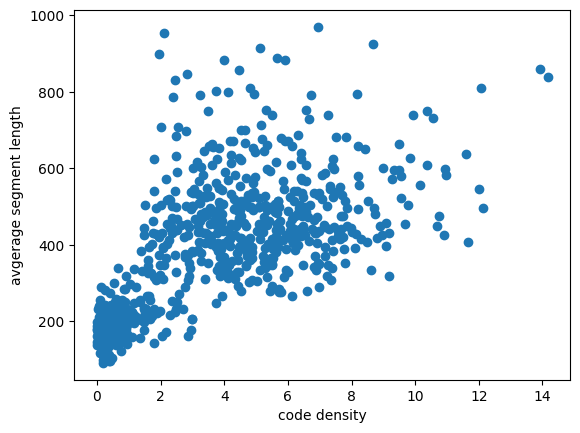

In [19]:
plt.scatter(x= codelingua_r1_l1.code_density, y = codelingua_r1_l1.avg_segment_len)
plt.xlabel("code density")
plt.ylabel("avgerage segment length")

Text(0, 0.5, 'word count')

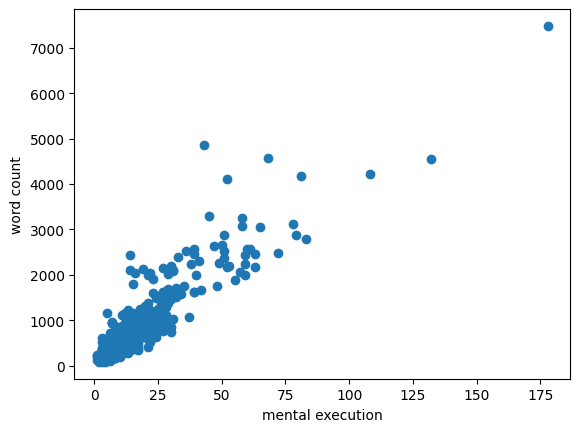

In [20]:
plt.scatter(x= crux_r1_l1.mental_execution, y = np.exp(crux_r1_l1.log_word_count))
plt.xlabel("mental execution")
plt.ylabel("word count")